# Kafka Dashboard - Real-Time Monitoring
Interactive notebook for monitoring Kafka streaming infrastructure and telemetry data flow


In [ ]:
import sys
import os
import pandas as pd
import numpy as np
import yaml
import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime

# Add project root to path
project_root = os.path.dirname(os.path.abspath(os.getcwd()))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.kafka_consumer import RealTimeConsumer
from src.kafka_producer import RealTimeProducer
from src.kafka_utils import get_topic_name, get_consumer_group_config


✅ Imports successful


## Configuration & Setup


In [ ]:
# Configuration
config_path = os.path.join(project_root, 'config', 'config.yaml')
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

kafka_config = config.get('kafka', {})
bootstrap_servers = kafka_config.get('bootstrap_servers', 'localhost:9092')

# Settings
DRIVER_IDS = ['VER']  # Change this to monitor specific drivers
MAX_POINTS = 500      # Maximum data points to keep in memory


📋 Configuration Loaded
   Bootstrap Servers: localhost:9092
   Driver Filter: ['VER']
   Max Data Points: 500


## Live Telemetry Monitor
Connect to Kafka and monitor incoming telemetry in real-time.

**Instructions:**
1. Ensure Kafka and the producer are running (from Streamlit or another source)
2. Run the cell below to start monitoring
3. Press **Interrupt Kernel** to stop monitoring


📊 Kafka Monitor - 500 messages | 22:35:34


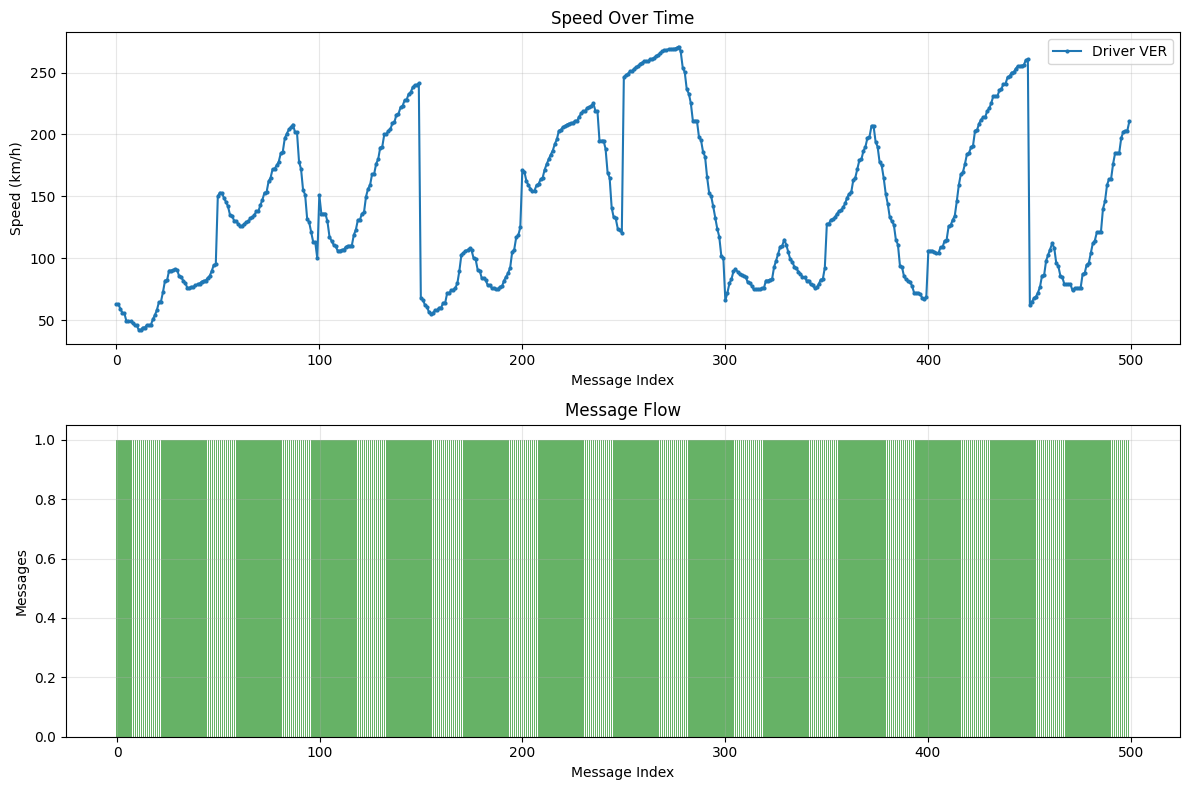

\n📈 Statistics:
   Avg Speed: 140.80 km/h
   Max Speed: 271.00 km/h
   Drivers: ['VER']


INFO:kafka.coordinator.heartbeat:Stopping heartbeat thread
INFO:kafka.coordinator:Leaving consumer group (notebook-monitor-group).
INFO:kafka.coordinator:LeaveGroup request for group notebook-monitor-group returned successfully
INFO:kafka.conn:<BrokerConnection client_id=kafka-python-2.2.15, node_id=1 host=localhost:9092 <connected> [IPv6 ('::1', 9092, 0, 0)]>: Closing connection. 
INFO:kafka.consumer.fetcher:Fetch to node 1 failed: Cancelled: <BrokerConnection client_id=kafka-python-2.2.15, node_id=1 host=localhost:9092 <connected> [IPv6 ('::1', 9092, 0, 0)]>
INFO:kafka.conn:<BrokerConnection client_id=kafka-python-2.2.15, node_id=coordinator-1 host=localhost:9092 <connected> [IPv6 ('::1', 9092, 0, 0)]>: Closing connection. 
INFO:src.kafka_consumer:Kafka consumer closed


\n🛑 Monitoring stopped
✅ Total messages collected: 500


In [3]:
# Initialize consumer
consumer_group = get_consumer_group_config('notebook_monitor', config=config)
topics = [get_topic_name('telemetry', config=config)]

consumer = RealTimeConsumer(
    config_path=config_path,
    consumer_group=consumer_group,
    topics=topics,
    driver_ids=DRIVER_IDS
)

# Data storage
telemetry_buffer = []

print("🔴 Starting live monitoring...")
print(f"   Consumer Group: {consumer_group}")
print(f"   Topics: {topics}")
print("   Press 'Interrupt Kernel' to stop\\n")

try:
    iteration = 0
    while True:
        # Poll for messages
        new_messages = consumer.poll_messages(timeout_ms=500, max_messages=50)
        
        if new_messages:
            for msg_dict in new_messages:
                msg = msg_dict.get('message', {})
                if msg.get('speed'):
                    telemetry_buffer.append({
                        'driver_id': msg.get('driver_id', 'UNKNOWN'),
                        'speed': msg.get('speed', 0),
                        'timestamp': msg.get('timestamp', ''),
                        'partition': msg_dict.get('partition', '')
                    })
            
            # Keep only last MAX_POINTS
            if len(telemetry_buffer) > MAX_POINTS:
                telemetry_buffer = telemetry_buffer[-MAX_POINTS:]
        
        # Update display every 5 iterations
        if iteration % 5 == 0 and telemetry_buffer:
            clear_output(wait=True)
            print(f"📊 Kafka Monitor - {len(telemetry_buffer)} messages | {datetime.now().strftime('%H:%M:%S')}")
            
            # Create plot
            df = pd.DataFrame(telemetry_buffer)
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
            
            # Speed plot
            for driver in df['driver_id'].unique():
                driver_data = df[df['driver_id'] == driver]
                ax1.plot(driver_data.index, driver_data['speed'], label=f'Driver {driver}', marker='o', markersize=2)
            ax1.set_title('Speed Over Time')
            ax1.set_xlabel('Message Index')
            ax1.set_ylabel('Speed (km/h)')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # Message rate
            ax2.bar(range(len(df)), [1]*len(df), alpha=0.6, color='green')
            ax2.set_title('Message Flow')
            ax2.set_xlabel('Message Index')
            ax2.set_ylabel('Messages')
            ax2.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            # Stats
            print(f"\\n📈 Statistics:")
            print(f"   Avg Speed: {df['speed'].mean():.2f} km/h")
            print(f"   Max Speed: {df['speed'].max():.2f} km/h")
            print(f"   Drivers: {df['driver_id'].unique().tolist()}")
        
        iteration += 1
        time.sleep(0.5)
        
except KeyboardInterrupt:
    print("\\n🛑 Monitoring stopped")
finally:
    if consumer and consumer.consumer:
        consumer.close()
    print(f"✅ Total messages collected: {len(telemetry_buffer)}")
